<a href="https://colab.research.google.com/github/federicocampo/Master-Thesis/blob/Changes/DNN_with_functional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
from tensorflow.keras import Sequential, Model, regularizers
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input, LayerNormalization, GaussianNoise
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import BinaryAccuracy, AUC, CategoricalAccuracy

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold, StratifiedGroupKFold

from tqdm import tqdm
import time

In [ ]:
sys.path.insert(1, "/content/gdrive/MyDrive/Codes")
from harmonization_randomforest import siteslist_new, convert_to_array, replace_nan

In [ ]:
#!pip install scikeras
#from scikeras.wrappers import KerasClassifier
!pip install git+https://github.com/rpomponio/neuroHarmonize
from neuroHarmonize import harmonizationLearn, harmonizationApply

  Cloning https://github.com/rpomponio/neuroHarmonize to /tmp/pip-req-build-nh8v8yc6
  Running command git clone -q https://github.com/rpomponio/neuroHarmonize /tmp/pip-req-build-nh8v8yc6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.8 MB 4.0 MB/s 
  Created wheel for neuroHarmonize: filename=neuroHarmonize-2.1.1-py3-none-any.whl size=17787 sha256=9ef624416b6637ebbf4e5f4f5978df1469898e7b3465cb84d0b86794774bed1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-iq20z5r_/wheels/cc/7c/da/a4141d7e0071e95ad8baed16f250eb7e0c27086ec2f0d1451d
Successfully built neuroHarmonize
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#!pip install shap
#import shap

#Functions

In [ ]:
def get_dataset(return_df = False, Data = 'zscore'):
  #Data can be: 'both', 'zscore', 'wave'
  atlas = 'homask'
  df1 = pd.read_csv(f'gdrive/MyDrive/MATLAB/data/dataset/df_homask_ab1_zscores&wave_new.csv')
  df2 = pd.read_csv(f'gdrive/MyDrive/MATLAB/data/dataset/df_homask_ab2_zscores&wave_new.csv')
  df2 = df2.rename(columns={"AGE_AT_SCAN ": "AGE_AT_SCAN"})

  df3 = pd.read_csv(f'gdrive/MyDrive/files_homask_no83/df3_homask.csv')
  df3 = df3.rename(columns={"Z_SCORE": "Z_DATA"})
  

  df2['SITE'] = df2['SITE'] + max(df1.SITE)
  df = pd.concat([df1, df2], ignore_index = True)
  df = pd.concat([df, df3], ignore_index = True)

  #df = df1

  df = df.rename(columns = {'SITE':'SITE_NUM'})
  df = df.rename(columns = {'SITE_ID':'SITE'})
  
  if Data == 'both':
    bad_list1 = np.where(pd.isnull(df.Z_DATA))[0]
    bad_list2 = np.where(pd.isnull(df.WCOHERENCE))[0]
    bad_list = np.concatenate((bad_list1, bad_list2))
    bad_list = np.unique(bad_list)
  elif Data == 'zscore': 
    bad_list = np.where(pd.isnull(df.Z_DATA))[0]
  elif Data == 'wave':
    bad_list = np.where(pd.isnull(df.WCOHERENCE))[0]
  else: raise ValueError("Data must be one of: 'both', 'zscore', 'wave'")

  df = df.drop(index = bad_list)
  df.reset_index(inplace = True, drop = True)

  #df = df.loc[(df.SITE != 'NYU_2') & (df.SITE != 'KUL_3')]
  df = df.loc[df.SEX == 1]
  #df = df.loc[df.AGE_AT_SCAN < 40]
  #void_eye_label = np.where(pd.isnull(df.EYE_STATUS_AT_SCAN))[0]
  #df = df.drop(index = void_eye_label)
  #Select just those with open/closed eyes
  #df = df.loc[df.EYE_STATUS_AT_SCAN == 1]
  df.reset_index(inplace = True, drop = True)

  if Data == 'both':
    zdata = df.Z_DATA
    XZ = convert_to_array(zdata)
    wdata = df.WCOHERENCE
    XW = convert_to_array(wdata)
    X = np.hstack((XZ, XW))
  elif Data == 'zscore': 
    zdata = df.Z_DATA
    X = convert_to_array(zdata)
  elif Data == 'wave':
    wdata = df.WCOHERENCE
    X = convert_to_array(wdata)

  
  labels = df.DX_GROUP.to_numpy(dtype = 'int16')
  y = labels
  
  y_site = df.SITE_NUM.to_numpy()
  from sklearn.preprocessing import OneHotEncoder
  y_site = y_site.reshape(-1, 1)
  enc = OneHotEncoder()
  y_site = enc.fit_transform(y_site).toarray()

  print('Data shape: ', X.shape)
  if return_df: return X, y, y_site, df
  else: return X, y, y_site

In [ ]:
def get_dataset_wave(return_df = False, Data = 'win'):
  #Data can be: 'both', 'win', 'wdown'
  df1 = pd.read_csv(f'gdrive/MyDrive/MATLAB/data/dataset/df_homask_ab1_wave_in+out.csv')
  #df1['ABIDE'] = 1
  df2 = pd.read_csv(f'gdrive/MyDrive/MATLAB/data/dataset/df_homask_ab2_wave_in+out.csv')
  df2 = df2.rename(columns={"AGE_AT_SCAN ": "AGE_AT_SCAN"})
  #df2['ABIDE'] = 0

  #df2['SITE'] = df2['SITE'] + max(df1.SITE)
  df = pd.concat([df1, df2], ignore_index = True)


  #df = df1

  df = df.rename(columns = {'SITE':'SITE_NUM'})
  df = df.rename(columns = {'SITE_ID':'SITE'})
  
  sites_list = siteslist_new(df, site_column_name = 'SITE', return_array = True, order = None)
  for site in sites_list:
    df.loc[df.SITE == site[0], 'SITE_NUM'] = site[1]


  if Data == 'both':
    bad_list1 = np.where(pd.isnull(df.WCOH_IN_PHASE))[0]
    bad_list2 = np.where(pd.isnull(df.WCOH_OUT_PHASE))[0]
    bad_list = np.concatenate((bad_list1, bad_list2))
    bad_list = np.unique(bad_list)
  elif Data == 'win': 
    bad_list = np.where(pd.isnull(df.WCOH_IN_PHASE))[0]
  elif Data == 'wout':
    bad_list = np.where(pd.isnull(df.WCOH_OUT_PHASE))[0]
  else: raise ValueError("Data must be one of: 'both', 'win', 'wout'")

  df = df.drop(index = bad_list)
  df.reset_index(inplace = True, drop = True)


  df = df.loc[df.SEX == 1]
  #void_eye_label = np.where(pd.isnull(df.EYE_STATUS_AT_SCAN))[0]
  #df = df.drop(index = void_eye_label)
  #Select just those with open/closed eyes
  #df = df.loc[df.EYE_STATUS_AT_SCAN == 1]
  df.reset_index(inplace = True, drop = True)

  if Data == 'both':
    data1 = df.WCOH_IN_PHASE
    data1 = convert_to_array(data1)
    data2 = df.WCOH_OUT_PHASE
    data2 = convert_to_array(data2)
    X = np.hstack((data1, data2))
  elif Data == 'win': 
    data = df.WCOH_IN_PHASE
    X = convert_to_array(data)
  elif Data == 'wout':
    data = df.WCOH_OUT_PHASE
    X = convert_to_array(data)

  
  labels = df.DX_GROUP.to_numpy(dtype = 'int16')
  y = labels
  
  y_site = df.SITE_NUM.to_numpy()
  from sklearn.preprocessing import OneHotEncoder
  y_site = y_site.reshape(-1, 1)
  enc = OneHotEncoder()
  y_site = enc.fit_transform(y_site).toarray()

  print('Data shape: ', X.shape)
  if return_df: return X, y, y_site, df
  else: return X, y, y_site

In [ ]:
def siteslist(readfile , site_name_column = 'SITE'):
  #Create a numpy array with shape = (N_site, 2) with
  #the name of the site in the first column and the numeric label in the second

  mydataframe = readfile[site_name_column]
  dummydf = pd.get_dummies(mydataframe)

  sites_list = []
  for site in dummydf.columns: #Iteration on each site's name
    sites_list.append(site)

  sites_list = np.array(sites_list)
  return sites_list


def remove_nan(x, y, y_site):
  nan_indices = np.unique(np.where(np.isnan(x))[0])
  if len(nan_indices) > 0:
    x = np.delete(x, nan_indices, axis = 0)
    y = np.delete(y, nan_indices, axis = 0)
    #y = np.delete(y, nan_indices)
    y_site = np.delete(y_site, nan_indices, axis = 0)
  print(f'found and removing {len(nan_indices)} out of {len(x)} NaN values')
  return x, y, y_site



#Models

In [ ]:

def make_model(learning_rate = 1e-4, momentum = None, input_shape = 11990):

  inputs = Input(shape=(input_shape,))
  x = Dense(64, activation = 'relu', name = 'feature_dense', )(inputs)
  x = BatchNormalization(name = 'feature_normalization')(x)
  x = Dropout(0.3, name = 'feature_dropout')(x)
  x = Dense(64, activation = 'relu', name = 'label_dense', )(x)
  x = BatchNormalization(name = 'label_normalization')(x)
  x = Dropout(0.3)(x)
  x = Dense(32, activation = 'relu', name = 'label_dense2', )(x)
  x = BatchNormalization(name = 'label_normalization2')(x)
  out = Dense(1, activation = 'sigmoid', name = 'label_output')(x)
  
  model = Model(inputs = inputs, outputs = out)
  optimizer = Adam(learning_rate = learning_rate)
  #optimizer = SGD()
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy', 'AUC'])
  return model



def make_model_sites():
  model = Sequential([
      Dense(128, activation = 'relu', name = 'feature_dense', ),
      BatchNormalization(name = 'feature_normalization'),
      Dropout(0.3, name = 'feature_dropout'),
      Dense(16, activation = 'relu', name = 'label_dense', ),
      BatchNormalization(name = 'label_normalization'),
      Dropout(0.3),
      Dense(35, activation = 'softmax', name = 'label_output')
  ])
  optimizer = Adam(learning_rate = 2e-3)
  #optimizer = SGD(learning_rate = 1e-3, momentum = 0.9)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy', 'AUC'])
  return model




#Training

In [ ]:
X, y, y_site, df = get_dataset(Data = 'zscore', return_df = True)
#X2, y, y_site, df = get_dataset_wave(Data = 'wout', return_df = True)
#X = X1-X2

Converting string data into array


Converting into array..: 100%|██████████| 1520/1520 [00:53<00:00, 28.62it/s]

Conversion complete! - Array shape:  (1520, 5995)
Data shape:  (1520, 5995)


### harmonization in kfold

In [ ]:
def training_kfold(X=X, y=y, y_site=y_site, df=df, n_pca = None):
  #if n_pca is None, pca technique is not run, 
  #otherwise, if it's a number, it's run and n_pca are extracted 

  acc_label_test_array = []
  auc_label_test_array = []
  acc_site_test_array = []
  auc_site_test_array = []

  scores = []

  harmon_features = ['SITE', 'AGE_AT_SCAN', 'FIQ']
  
  kfold = StratifiedKFold(n_splits = 5,  shuffle = True, random_state = 42 ).split(X, y)
  for k, (train, test) in enumerate(kfold):
    print(f'-----Fold {k+1}-----')
    # cotr = control_train, cote = control_test, catr = case_train, cate = case_test 
    X_harmon = np.zeros((X.shape))

    # Control Train COTR
    df_control_train = df.iloc[train].loc[df.DX_GROUP == 0]
    ind_cotr = df_control_train.index.to_numpy()
    control_train = X[ind_cotr]
    df_for_harmon = df_control_train[harmon_features]
    harmon_model, harmon_control_train = harmonizationLearn(control_train, df_for_harmon)
    X_harmon[ind_cotr] = harmon_control_train

    # Case Train CATR
    df_case_train = df.iloc[train].loc[df.DX_GROUP == 1]
    ind_catr = df_case_train.index.to_numpy()
    case_train = X[ind_catr]
    df_holdout = df_case_train[harmon_features]
    harmon_case_train = harmonizationApply(case_train, df_holdout, harmon_model)
    X_harmon[ind_catr] = harmon_case_train

    # Control Test COTE
    df_control_test = df.iloc[test].loc[df.DX_GROUP == 0]
    ind_cote = df_control_test.index.to_numpy()
    control_test = X[ind_cote]
    df_holdout = df_control_test[harmon_features]
    harmon_control_test = harmonizationApply(control_test, df_holdout, harmon_model)
    X_harmon[ind_cote] = harmon_control_test

    # Case Test CATE
    df_case_test = df.iloc[test].loc[df.DX_GROUP == 1]
    ind_cate = df_case_test.index.to_numpy()
    case_test = X[ind_cate]
    df_holdout = df_case_test[harmon_features]
    harmon_case_test  = harmonizationApply(case_test, df_holdout, harmon_model)
    X_harmon[ind_cate] = harmon_case_test

    # -- EXTRACTING X, y, y_site train and test --
    X_harmon = replace_nan(X, X_harmon)

    X_train = np.array(X_harmon[train])
    X_test = np.array(X_harmon[test])

    if n_pca is not None:
      pca = PCA(n_components = n_pca)
      pca.fit(X_train)
      X_train_pca = pca.transform(X_train)
      X_test_pca = pca.transform(X_test)
      X_train = X_train_pca
      X_test = X_test_pca

    y_train = np.array(y[train])
    y_test = np.array(y[test])

    y_site_train = np.array(y_site[train])
    y_site_test = np.array(y_site[test])

    #Define and fit the model
    assert X_train.shape[1] == X_test.shape[1]
    model = make_model(input_shape = X_train.shape[1])
    model.fit(X_train, y_train, epochs = 30, validation_split = 0, verbose = 0)

    #Get model results
    evaluations = model.evaluate(X_test, y_test)
    acc_label_test = evaluations[1]
    acc_label_test_array.append(acc_label_test)
    auc_label_test = evaluations[2]
    auc_label_test_array.append(auc_label_test)


    forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
    forest.fit(X_train, y_train)
    score = forest.score(X_test, y_test)
    scores.append(score)

  #Visualize average model's performances
  print('Accuracy = ', acc_label_test_array)
  print('AUC = ', auc_label_test_array)
  print(f'\nAccuracy mean = {np.mean(acc_label_test_array):.2f} +\- {np.std(acc_label_test_array):.2f}')
  print(f'AUC mean = {np.mean(auc_label_test_array):.2f} +\- {np.std(auc_label_test_array):.2f}')
  print(f'RandomForest Score: {np.mean(scores)} +\- {np.std(scores)}')
  return

In [ ]:
training_kfold()

-----Fold 1-----
found and replace 51 out of 1467 NaN values
10/10 [==============================] - 0s 3ms/step - loss: 0.8130 - binary_accuracy: 0.5816 - auc: 0.6539
-----Fold 2-----
found and replace 51 out of 1467 NaN values
10/10 [==============================] - 0s 3ms/step - loss: 0.8704 - binary_accuracy: 0.5986 - auc: 0.6542
-----Fold 3-----
found and replace 51 out of 1467 NaN values
10/10 [==============================] - 0s 3ms/step - loss: 0.7883 - binary_accuracy: 0.6655 - auc: 0.7087
-----Fold 4-----
found and replace 51 out of 1467 NaN values
10/10 [==============================] - 0s 3ms/step - loss: 0.8188 - binary_accuracy: 0.5904 - auc: 0.6813
-----Fold 5-----
found and replace 51 out of 1467 NaN values
10/10 [==============================] - 0s 3ms/step - loss: 0.7301 - binary_accuracy: 0.6280 - auc: 0.6992
Accuracy =  [0.581632673740387, 0.5986394286155701, 0.6655290126800537, 0.5904436707496643, 0.6279863715171814]
AUC =  [0.6539336442947388, 0.6542121171951

###Harmonization on the whole train dataset

In [ ]:
def training_kfold_harmotrain(X=X, y=y, y_site=y_site, df=df, n_pca = None, momentum = None ):
  #X, y, y_site, df = get_dataset(return_df = True)


  acc_label_test_array = []
  auc_label_test_array = []
  acc_site_test_array = []
  auc_site_test_array = []

  scores = []

  harmon_features = ['SITE', 'AGE_AT_SCAN', 'FIQ']
  kfold = StratifiedKFold(n_splits = 5,  shuffle = True, random_state = 42 ).split(X, y)
  for k, (train, test) in enumerate(kfold):
    print(f'-----Fold {k+1}-----')

    X_harmon = np.zeros((X.shape))

    # Train 
    df_train = df.iloc[train]
    ind_train = df_train.index.to_numpy()
    x_train = X[ind_train]
    df_for_harmon = df_train[harmon_features]
    harmon_model, harmon_train = harmonizationLearn(x_train, df_for_harmon)
    X_harmon[ind_train] = harmon_train
    # Test
    df_test = df.iloc[test]
    ind_test = df_test.index.to_numpy()
    x_test = X[ind_test]
    df_for_harmon = df_test[harmon_features]
    harmon_test = harmonizationApply(x_test, df_for_harmon, harmon_model)
    X_harmon[ind_test] = harmon_test

    X_harmon = replace_nan(X, X_harmon)

    X_train = np.array(X_harmon[train])
    X_test = np.array(X_harmon[test])

    y_train = np.array(y[train])
    y_test = np.array(y[test])


    #Define and fit the model
    model = make_model(input_shape = X.shape[1])
    model.fit(X_train, y_train, epochs = 30, validation_split = 0, verbose = 0)

    #Get model results
    evaluations = model.evaluate(X_test, y_test)
    acc_label_test = evaluations[1]
    acc_label_test_array.append(acc_label_test)
    auc_label_test = evaluations[2]
    auc_label_test_array.append(auc_label_test)


    forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
    forest.fit(X_train, y_train)
    score = forest.score(X_test, y_test)
    scores.append(score)

  #Visualize average model's performances
  print('Accuracy = ', acc_label_test_array)
  print('AUC = ', auc_label_test_array)
  print(f'\nAccuracy mean = {np.mean(acc_label_test_array):.2f} +\- {np.std(acc_label_test_array):.2f}')
  print(f'AUC mean = {np.mean(auc_label_test_array):.2f} +\- {np.std(auc_label_test_array):.2f}')
  print(f'RandomForest Score: {np.mean(scores)} +\- {np.std(scores)}')
  return

In [ ]:
training_kfold_harmotrain()

-----Fold 1-----
found and replace 0 out of 1494 NaN values
10/10 [==============================] - 0s 3ms/step - loss: 1.1022 - binary_accuracy: 0.5853 - auc: 0.6399
-----Fold 2-----
found and replace 0 out of 1494 NaN values
10/10 [==============================] - 0s 4ms/step - loss: 1.2741 - binary_accuracy: 0.5418 - auc: 0.5820
-----Fold 3-----
found and replace 0 out of 1494 NaN values
10/10 [==============================] - 0s 4ms/step - loss: 1.2490 - binary_accuracy: 0.5953 - auc: 0.6163
-----Fold 4-----
found and replace 0 out of 1494 NaN values
10/10 [==============================] - 0s 3ms/step - loss: 1.1503 - binary_accuracy: 0.6154 - auc: 0.6406
-----Fold 5-----
found and replace 0 out of 1494 NaN values
10/10 [==============================] - 0s 3ms/step - loss: 1.2170 - binary_accuracy: 0.5470 - auc: 0.5841
Accuracy =  [0.5852842926979065, 0.5418060421943665, 0.5953177213668823, 0.6153846383094788, 0.5469798445701599]
AUC =  [0.6399416923522949, 0.5819668769836426,

### train harmonize all indiscriminately

In [ ]:
def training_kfold_harmo_all(X=X, y=y, y_site=y_site, df=df, n_pca = None, momentum = None ):
  #X, y, y_site, df = get_dataset(return_df = True)


  acc_label_test_array = []
  auc_label_test_array = []
  acc_site_test_array = []
  auc_site_test_array = []

  scores = []
    
  harmon_features = ['SITE', 'AGE_AT_SCAN', 'FIQ']
  df_harmon = df[harmon_features]
  harmon_model, harmon_data = harmonizationLearn(X, df_harmon)

  X_harmon = replace_nan(X, harmon_data)

  kfold = StratifiedKFold(n_splits = 5,  shuffle = True, random_state = 42 ).split(X, y)
  for k, (train, test) in enumerate(kfold):
    print(f'-----Fold {k+1}-----')
    # cotr = control_train, cote = control_test, catr = case_train, cate = case_test 


    X_train = np.array(X_harmon[train])
    X_test = np.array(X_harmon[test])

    y_train = np.array(y[train])
    y_test = np.array(y[test])

    #Define and train the model
    model = make_model(input_shape = X.shape[1])
    model.fit(X_train, y_train, epochs = 30, validation_split = 0, verbose = 0)

    #Get model results
    evaluations = model.evaluate(X_test, y_test)
    acc_label_test = evaluations[1]
    acc_label_test_array.append(acc_label_test)
    auc_label_test = evaluations[2]
    auc_label_test_array.append(auc_label_test)


    forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
    forest.fit(X_train, y_train)
    score = forest.score(X_test, y_test)
    scores.append(score)

  #Visualize average model's performances
  print('Accuracy = ', acc_label_test_array)
  print('AUC = ', auc_label_test_array)
  print(f'\nAccuracy mean = {np.mean(acc_label_test_array):.2f} +\- {np.std(acc_label_test_array):.2f}')
  print(f'AUC mean = {np.mean(auc_label_test_array):.2f} +\- {np.std(auc_label_test_array):.2f}')
  print(f'RandomForest Score: {np.mean(scores)} +\- {np.std(scores)}')
  return

In [ ]:
training_kfold_harmo_all()

found and replace 0 out of 1494 NaN values
-----Fold 1-----
10/10 [==============================] - 0s 3ms/step - loss: 1.1097 - binary_accuracy: 0.5920 - auc: 0.6501
-----Fold 2-----
10/10 [==============================] - 0s 3ms/step - loss: 1.2650 - binary_accuracy: 0.5853 - auc: 0.5776
-----Fold 3-----
10/10 [==============================] - 0s 4ms/step - loss: 1.3853 - binary_accuracy: 0.5619 - auc: 0.5845
-----Fold 4-----
10/10 [==============================] - 0s 3ms/step - loss: 1.1923 - binary_accuracy: 0.6087 - auc: 0.6377
-----Fold 5-----
10/10 [==============================] - 0s 3ms/step - loss: 1.1684 - binary_accuracy: 0.6107 - auc: 0.6253
Accuracy =  [0.5919732451438904, 0.5852842926979065, 0.5618728995323181, 0.6086956262588501, 0.6107382774353027]
AUC =  [0.6500672101974487, 0.5775985717773438, 0.5845275521278381, 0.63768470287323, 0.6252705454826355]

Accuracy mean = 0.59 +\- 0.02
AUC mean = 0.62 +\- 0.03
RandomForest Score: 0.5930349487104667 +\- 0.022805931334

### NO harmonization

In [ ]:
def training_kfold_noharmo(X=X, y=y, y_site=y_site, df=df, n_pca = None ):
  #X, y, y_site, df = get_dataset(return_df = True)


  acc_label_test_array = []
  auc_label_test_array = []
  acc_site_test_array = []
  auc_site_test_array = []

  scores = []

  
  kfold = StratifiedKFold(n_splits = 5,  shuffle = True, random_state = 42 ).split(X, y)
  for k, (train, test) in enumerate(kfold):
    print(f'-----Fold {k+1}-----')
    # cotr = control_train, cote = control_test, catr = case_train, cate = case_test 
 

    X_train = np.array(X[train])
    X_test = np.array(X[test])


    if n_pca is not None:
      pca = PCA(n_components = n_pca)
      pca.fit(X_train)
      X_train_pca = pca.transform(X_train)
      X_test_pca = pca.transform(X_test)
      X_train = X_train_pca
      X_test = X_test_pca
    assert X_train.shape[1] == X_test.shape[1]
    print('Shape of train data input to ML: ', X_train.shape)

    y_train = np.array(y[train])
    y_test = np.array(y[test])


    #Define and fit the model
    model = make_model(input_shape = X_train.shape[1])
    history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.1, verbose = 0)
    print(history.history.keys())
    if k == 0:
      plt.figure(1)
      plt.plot(history.history['binary_accuracy'])
      plt.plot(history.history['val_binary_accuracy'])
      plt.figure(2)
      plt.plot(history.history['auc'])
      plt.plot(history.history['val_auc'])
      plt.show()
    #Get model results
    evaluations = model.evaluate(X_test, y_test)
    acc_label_test = evaluations[1]
    acc_label_test_array.append(acc_label_test)
    auc_label_test = evaluations[2]
    auc_label_test_array.append(auc_label_test)


    forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
    forest.fit(X_train, y_train)
    score = forest.score(X_test, y_test)
    scores.append(score)
    
  #Visualize average model's performances
  print('Accuracy = ', acc_label_test_array)
  print('AUC = ', auc_label_test_array)
  print(f'\nAccuracy mean = {np.mean(acc_label_test_array):.2f} +\- {np.std(acc_label_test_array):.2f}')
  print(f'AUC mean = {np.mean(auc_label_test_array):.2f} +\- {np.std(auc_label_test_array):.2f}')
  print(f'RandomForest Score: {np.mean(scores)} +\- {np.std(scores)}')
  return

-----Fold 1-----
Shape of train data input to ML:  (1216, 5995)
dict_keys(['loss', 'binary_accuracy', 'auc', 'val_loss', 'val_binary_accuracy', 'val_auc'])


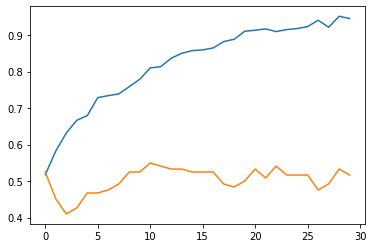

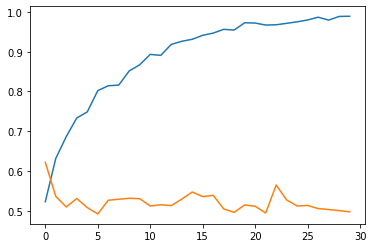

10/10 [==============================] - 0s 3ms/step - loss: 0.8299 - binary_accuracy: 0.6382 - auc: 0.6749
-----Fold 2-----
Shape of train data input to ML:  (1216, 5995)
dict_keys(['loss', 'binary_accuracy', 'auc', 'val_loss', 'val_binary_accuracy', 'val_auc'])
10/10 [==============================] - 0s 3ms/step - loss: 0.6734 - binary_accuracy: 0.6645 - auc: 0.7317
-----Fold 3-----
Shape of train data input to ML:  (1216, 5995)
dict_keys(['loss', 'binary_accuracy', 'auc', 'val_loss', 'val_binary_accuracy', 'val_auc'])
10/10 [==============================] - 0s 3ms/step - loss: 0.8389 - binary_accuracy: 0.6217 - auc: 0.6545
-----Fold 4-----
Shape of train data input to ML:  (1216, 5995)
dict_keys(['loss', 'binary_accuracy', 'auc', 'val_loss', 'val_binary_accuracy', 'val_auc'])
10/10 [==============================] - 0s 4ms/step - loss: 0.8783 - binary_accuracy: 0.6217 - auc: 0.6725
-----Fold 5-----
Shape of train data input to ML:  (1216, 5995)
dict_keys(['loss', 'binary_accuracy'

In [ ]:
training_kfold_noharmo()

###Harmonize all dataset on control and apply to all cases

In [ ]:
def training_kfold_harmo_all_controls(X=X, y=y, y_site=y_site, df=df, n_pca = None, momentum = None ):
  #X, y, y_site, df = get_dataset(return_df = True)

  X_harmon = np.zeros_like(X)

  acc_label_test_array = []
  auc_label_test_array = []
  acc_site_test_array = []
  auc_site_test_array = []

  scores = []
    
  harmon_features = ['SITE', 'AGE_AT_SCAN', 'FIQ']

  df_c = df.loc[df.DX_GROUP == 0]
  index_c = df_c.index.to_numpy()
  df_c = df_c.reset_index(drop = True)

  x_c = np.array(X[index_c])

  df_c_harmon = df_c[harmon_features]
  harmon_model, x_c_harmon = harmonizationLearn(x_c, df_c_harmon)


  df_asd = df.loc[df.DX_GROUP == 1]
  index_asd = df_asd.index.to_numpy()
  df_asd = df_asd.reset_index(drop = True)

  x_asd =np.array(X[index_asd])

  df_asd_harmon = df_asd[harmon_features]
  x_asd_harmon = harmonizationApply(x_asd, df_asd_harmon, harmon_model)

  X_harmon[index_c] = x_c_harmon
  X_harmon[index_asd] = x_asd_harmon

  X_harmon = replace_nan(X, X_harmon)

  kfold = StratifiedKFold(n_splits = 5,  shuffle = True, random_state = 42 ).split(X, y)
  for k, (train, test) in enumerate(kfold):
    print(f'-----Fold {k+1}-----')
    # cotr = control_train, cote = control_test, catr = case_train, cate = case_test 


    X_train = np.array(X_harmon[train])
    X_test = np.array(X_harmon[test])

    y_train = np.array(y[train])
    y_test = np.array(y[test])

    #Define and train the model
    model = make_model(input_shape = X.shape[1])
    model.fit(X_train, y_train, epochs = 30, validation_split = 0, verbose = 0)

    #Get model results
    evaluations = model.evaluate(X_test, y_test)
    acc_label_test = evaluations[1]
    acc_label_test_array.append(acc_label_test)
    auc_label_test = evaluations[2]
    auc_label_test_array.append(auc_label_test)


    forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
    forest.fit(X_train, y_train)
    score = forest.score(X_test, y_test)
    scores.append(score)

  #Visualize average model's performances
  print('Accuracy = ', acc_label_test_array)
  print('AUC = ', auc_label_test_array)
  print(f'\nAccuracy mean = {np.mean(acc_label_test_array):.2f} +\- {np.std(acc_label_test_array):.2f}')
  print(f'AUC mean = {np.mean(auc_label_test_array):.2f} +\- {np.std(auc_label_test_array):.2f}')
  print(f'RandomForest Score: {np.mean(scores)} +\- {np.std(scores)}')
  return

In [ ]:
training_kfold_harmo_all_controls()

found and replace 51 out of 1494 NaN values
-----Fold 1-----
10/10 [==============================] - 0s 3ms/step - loss: 0.9580 - binary_accuracy: 0.6288 - auc: 0.7255
-----Fold 2-----
10/10 [==============================] - 0s 2ms/step - loss: 0.9581 - binary_accuracy: 0.6488 - auc: 0.7140
-----Fold 3-----
10/10 [==============================] - 0s 3ms/step - loss: 0.9635 - binary_accuracy: 0.6321 - auc: 0.7116
-----Fold 4-----
10/10 [==============================] - 0s 3ms/step - loss: 0.6891 - binary_accuracy: 0.7391 - auc: 0.7967
-----Fold 5-----
10/10 [==============================] - 0s 4ms/step - loss: 1.1011 - binary_accuracy: 0.6074 - auc: 0.6879
Accuracy =  [0.6287625432014465, 0.648829460144043, 0.6321070194244385, 0.739130437374115, 0.6073825359344482]
AUC =  [0.7255375981330872, 0.7139784693717957, 0.7115539908409119, 0.796686053276062, 0.6879058480262756]

Accuracy mean = 0.65 +\- 0.05
AUC mean = 0.73 +\- 0.04
RandomForest Score: 0.6546429934232677 +\- 0.018437821793

# **ADVERSARIAL**

##Define the adv model

In [ ]:
@tf.custom_gradient
def gradient_reverse_func(x, lamda=1):
  y = tf.identity(x)
  def grad(dy):
    return -(lamda * dy), None
  return y, grad


class GradientReversalLayer(Layer):
  def __init__(self):
      super().__init__()

  def call(self, x, lamda=1):
      return gradient_reverse_func(x, lamda)


def loss_labels(y_true, y_pred):
  loss_label = BinaryCrossentropy()(y_true, y_pred)
  return loss_label


def loss_sites(y_site_true, out_site_pred):

  TOT_sites = len(y_site_true[0])
  assert len(y_site_true) == len(out_site_pred)
  for i in range(len(y_site_true)):
    #print(y_site_true[i], out_site_pred[i])
    index_y_site_pred = np.argmax(out_site_pred[i])
    index_y_site_true = np.argmax(y_site_true[i])
    if index_y_site_pred != index_y_site_true:
      pass
    else:
      allowed_values = list(range(0, TOT_sites))
      allowed_values.remove(index_y_site_true)
      random_value = np.random.choice(allowed_values)
      x = np.zeros(TOT_sites)
      x[random_value] = 1.0
      x = tf.convert_to_tensor(x, dtype = tf.float32)
      a = tf.unstack(y_site_true)
      a[i] = x
      y_site_true = tf.stack(a)

  y_site_true = tf.convert_to_tensor(y_site_true)
  out_site_pred = tf.convert_to_tensor(out_site_pred)
  loss_site = CategoricalCrossentropy()(y_site_true, out_site_pred)
  return loss_site




def make_adversarial_model(input_shape, num_sites):
  inputs = Input(shape = input_shape)

  feat = Dense(64, activation = 'relu', name = 'feature_dense0')(inputs)
  feat = BatchNormalization(name = 'feature_normalization0')(feat)
  feat = Dropout(0.3, name = 'feature_dropout0')(feat)

  feat = Dense(64, activation = 'relu', name = 'feature_dense1')(feat)
  feat = BatchNormalization(name = 'feature_normalization1')(feat)
  feat = Dropout(0.3, name = 'feature_dropout1')(feat)

  out1 = Dense(32, activation = 'relu', name = 'label_dense')(feat)
  out1 = BatchNormalization(name = 'label_normalization')(out1)
  out_label = Dense(1, activation = 'sigmoid', name = 'label_output')(out1)

  out2 = GradientReversalLayer()(feat) # REMEMBER to link this gradient_reversal with the layer below
  out2 = Dense(16, activation = 'relu', name = 'site_dense')(out2)
  out2 = BatchNormalization(name = 'site_normalization')(out2)
  out_site = Dense(num_sites, activation = 'softmax', name = 'site_output')(out2)

  kerasmodel = Model(inputs = inputs, outputs = [out_label, out_site])
  kerasmodel.compile(
                    loss={'label_output':loss_labels,
                          'site_output': loss_sites},
                    optimizer='adam',
                    metrics={'label_output':['binary_accuracy', 'AUC'], 'site_output': 'categorical_accuracy'},
                    loss_weights = (1, 1),
                    run_eagerly = True
                    )
  return kerasmodel

## Train the adv model

In [ ]:
X, y, y_site, df = get_dataset(Data = 'zscore', return_df = True)

Converting string data into array


Converting into array..: 100%|██████████| 1494/1494 [00:54<00:00, 27.26it/s]

Conversion complete! - Array shape:  (1494, 5995)
Data shape:  (1494, 5995)


In [ ]:
def kfold_adv(X=X, y=y, y_site=y_site, df=df):
  
  acc_label_test_array = []
  auc_label_test_array = []
  acc_site_test_array = []
  auc_site_test_array = []

  scores = []

  
  kfold = StratifiedKFold(n_splits = 5,  shuffle = True, random_state = 42 ).split(X, y)
  for k, (train, test) in enumerate(kfold):
    print(f'-----Fold {k+1}-----')


    X_train = np.array(X[train])
    X_test = np.array(X[test])

    y_train = np.array(y[train])
    y_test = np.array(y[test])

    y_site_train = np.array(y_site[train])
    y_site_test = np.array(y_site[test])

  
    #X_train, y_train, y_site_train = remove_nan(X_train, y_train, y_site_train)
    #X_test, y_test, y_site_test = remove_nan(X_test, y_test, y_site_test)
    
    #Define and fit the model
    num_sites = len(y_site[0])
    model = make_adversarial_model(input_shape = X.shape[1], num_sites = num_sites)
    model.fit(X_train, [y_train, y_site_train], epochs = 30, validation_split = 0.1, verbose = 1)
    #Get model results
    evaluations = model.evaluate(X_test, [y_test, y_site_test])
    acc_label_test = evaluations[3]
    acc_label_test_array.append(acc_label_test)
    auc_label_test = evaluations[4]
    auc_label_test_array.append(auc_label_test)


    forest = RandomForestClassifier(random_state = 42)
    forest.fit(X_train, y_train)
    score = forest.score(X_test, y_test)
    scores.append(score)

  #Visualize average model's performances
  print('Accuracy = ', acc_label_test_array)
  print('AUC = ', auc_label_test_array)
  print(f'\nAccuracy mean = {np.mean(acc_label_test_array):.2f} +\- {np.std(acc_label_test_array):.2f}')
  print(f'AUC mean = {np.mean(auc_label_test_array):.2f} +\- {np.std(auc_label_test_array):.2f}')
  print(f'RandomForest Score: {np.mean(scores)} +\- {np.std(scores)}')
  return

In [ ]:
kfold_adv()

-----Fold 1-----
Epoch 1/30
34/34 [==============================] - 4s 99ms/step - loss: 4.8644 - label_output_loss: 0.8369 - site_output_loss: 4.0275 - label_output_binary_accuracy: 0.5507 - label_output_auc: 0.5641 - site_output_categorical_accuracy: 0.0195 - val_loss: 4.7247 - val_label_output_loss: 0.7747 - val_site_output_loss: 3.9500 - val_label_output_binary_accuracy: 0.4750 - val_label_output_auc: 0.5246 - val_site_output_categorical_accuracy: 0.0000e+00
Epoch 2/30
34/34 [==============================] - 4s 112ms/step - loss: 4.7995 - label_output_loss: 0.6738 - site_output_loss: 4.1257 - label_output_binary_accuracy: 0.6177 - label_output_auc: 0.6664 - site_output_categorical_accuracy: 0.0102 - val_loss: 4.5646 - val_label_output_loss: 0.6426 - val_site_output_loss: 3.9220 - val_label_output_binary_accuracy: 0.6167 - val_label_output_auc: 0.6773 - val_site_output_categorical_accuracy: 0.0000e+00
Epoch 3/30
34/34 [==============================] - 3s 85ms/step - loss: 4.6881 

# **Features study**

In [ ]:
df.SITE_NUM

0       18.0
1       18.0
2       18.0
3       18.0
4       18.0
        ... 
1489     NaN
1490     NaN
1491     NaN
1492     NaN
1493     NaN
Name: SITE_NUM, Length: 1494, dtype: float64

X data extraction

In [ ]:
X, y, y_site, df = get_dataset(return_df = True)

Converting string data into array


Converting into array..: 100%|██████████| 1009/1009 [00:40<00:00, 25.20it/s]


Conversion complete! - Array shape:  (1009, 5995)
Data shape:  (1009, 5995)


In [ ]:
df.SITE

0         KKI
1         KKI
2         KKI
3         KKI
4         KKI
        ...  
1004    USM_1
1005    USM_1
1006    USM_1
1007    USM_1
1008    USM_1
Name: SITE, Length: 1009, dtype: object

In [ ]:
y_site = df.SITE_NUM.to_numpy()
from sklearn.preprocessing import OneHotEncoder
y_site = y_site.reshape(-1, 1)
enc = OneHotEncoder()
y_site = enc.fit_transform(y_site).toarray()

In [ ]:
len(siteslist_new(df, 'SITE'))

24

In [ ]:
Data = 'zscore' 
#Data can be: 'both', 'zscore', 'wave'
atlas = 'homask'
df1 = pd.read_csv(f'gdrive/MyDrive/MATLAB/data/dataset/df_homask_ab1_zscores&wave_new.csv')
#df1['ABIDE'] = 1
df2 = pd.read_csv(f'gdrive/MyDrive/MATLAB/data/dataset/df_homask_ab2_zscores&wave_new.csv')
df2 = df2.rename(columns={"AGE_AT_SCAN ": "AGE_AT_SCAN"})
#df2['ABIDE'] = 0

In [ ]:
df2['SITE'] = df2['SITE'] + max(df1.SITE)
df = pd.concat([df1, df2], ignore_index = True)
#df = df1
df = df.rename(columns={'SITE':'SITE_NUM'})
df = df.rename(columns={'SITE_ID':'SITE'})

In [ ]:
df

,Unnamed: 0,SITE,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,ADI_R_C3_TOTAL,ADI_R_C4_REPETITIVE_USE_OBJECTS,ADI_R_C4_HIGHER,ADI_R_C4_UNUSUAL_SENSORY_INTERESTS,ADI_R_C4_TOTAL,ADI_R_D_AGE_PARENT_NOTICED,ADI_R_D_AGE_FIRST_SINGLE_WORDS,ADI_R_D_AGE_FIRST_PHRASES,ADI_R_D_AGE_WHEN_ABNORMALITY,ADI_R_D_INTERVIEWER_JUDGMENT
0,0,CALTECH,51456,1,4.0,55.4000,1,R,NaN,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CALTECH,51457,1,4.0,22.9000,1,Ambi,NaN,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,CALTECH,51458,1,1.0,39.2000,1,R,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,CALTECH,51459,1,1.0,22.8000,1,R,NaN,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,CALTECH,51460,1,1.0,34.6000,2,Ambi,NaN,133.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,1109,USM_1,29523,0,NaN,36.1451,1,NaN,NaN,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2222,1110,USM_1,29524,0,NaN,11.7892,1,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2223,1111,USM_1,29525,0,NaN,23.2909,1,1.0,80.0,123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2224,1112,USM_1,29526,0,NaN,32.6242,1,NaN,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bad_list = np.where(pd.isnull(df.Z_DATA))[0]
df = df.drop(index = bad_list)
df = df.loc[df.SEX == 1]
df.reset_index(inplace = True)



Converting string data into array


Converting into array..: 100%|██████████| 1494/1494 [01:11<00:00, 20.86it/s]

Conversion complete! - Array shape:  (1494, 5995)


In [ ]:
zdata = df.Z_DATA
X = convert_to_array(zdata)

0       [0.36952, 0.31981, 0.26097, 0.48041, 0.09843, ...
1       [0.44973, 0.71205, 0.45856, 0.55126, 0.20815, ...
2       [0.32338, 0.47272, 0.24363, 0.24578, 0.21664, ...
3       [0.61922, 0.48413, 0.59632, 0.65231, 0.50707, ...
4       [0.39808, 0.3645, 0.20048, 0.68457, 0.24627, 0...
                              ...                        
1489    [0.21759, 0.14693, 0.012, 0.59226, 0.26091, 0....
1490    [0.10472, 0.45626, 0.00926, 0.52005, 0.29833, ...
1491    [0.25405, 0.70716, 0.14374, 0.51723, 0.10516, ...
1492    [0.37765, 0.61589, 0.55335, 0.87352, 0.25241, ...
1493    [0.14786, 0.53092, 0.43885, 0.60164, 0.4639, 0...
Name: Z_DATA, Length: 1494, dtype: object

In [ ]:
X.shape

(1494, 5995)

In [ ]:
labels = df.DX_GROUP.to_numpy(dtype = 'int16')

In [ ]:
labels.shape

(1494,)

In [ ]:
harmon_features = ['AGE_AT_SCAN', 'FIQ', 'SITE']

In [ ]:
df_for_harmon = df[harmon_features]
df_for_harmon

,AGE_AT_SCAN,FIQ,SITE
0,55.4000,126.0,CALTECH
1,22.9000,107.0,CALTECH
2,39.2000,93.0,CALTECH
3,22.8000,106.0,CALTECH
4,37.7000,99.0,CALTECH
...,...,...,...
1489,27.4114,143.0,USM_1
1490,36.1451,115.0,USM_1
1491,11.7892,99.0,USM_1
1492,23.2909,123.0,USM_1


In [ ]:
harmon_model, harmon_data = harmonizationLearn(X, df_for_harmon)

In [ ]:
X

array([[0.36952, 0.31981, 0.26097, ..., 0.76463, 0.21209, 0.88933],
       [0.44973, 0.71205, 0.45856, ..., 0.02276, 0.02599, 1.09157],
       [0.32338, 0.47272, 0.24363, ..., 0.28356, 0.18789, 0.67994],
       ...,
       [0.25405, 0.70716, 0.14374, ..., 0.27764, 0.48515, 1.34307],
       [0.37765, 0.61589, 0.55335, ..., 0.10417, 0.23849, 1.15414],
       [0.14786, 0.53092, 0.43885, ..., 0.21224, 0.31614, 0.93404]],
      dtype=float32)

In [ ]:
#np.unique(np.where(np.isnan(harmon_data))[0])

array([], dtype=int64)

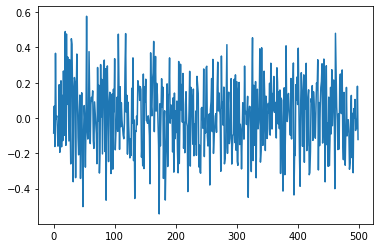

In [ ]:
plt.plot(np.arange(len(data)), data)

Harmonization

In [ ]:
harmon_features = ['SITE', 'AGE_AT_SCAN', 'FIQ']

X_harmon = np.zeros((X.shape))
#X_harmon = X

# Control
df_control = df.loc[df.DX_GROUP == 0]
ind_control = df_control.index.to_numpy()
X_control = X[ind_control]
df_for_harmon = df_control[harmon_features]
harmon_model, harmon_control = harmonizationLearn(X_control, df_for_harmon)
X_harmon[ind_control] = harmon_control

# Case 
df_case = df.loc[df.DX_GROUP == 1]
ind_case = df_case.index.to_numpy()
X_case = X[ind_case]
df_holdout = df_case[harmon_features]
harmon_case = harmonizationApply(X_case, df_holdout, harmon_model)
X_harmon[ind_case] = harmon_case

X_harmon = replace_nan(X, X_harmon)

found and replace 51 out of 1494 NaN values


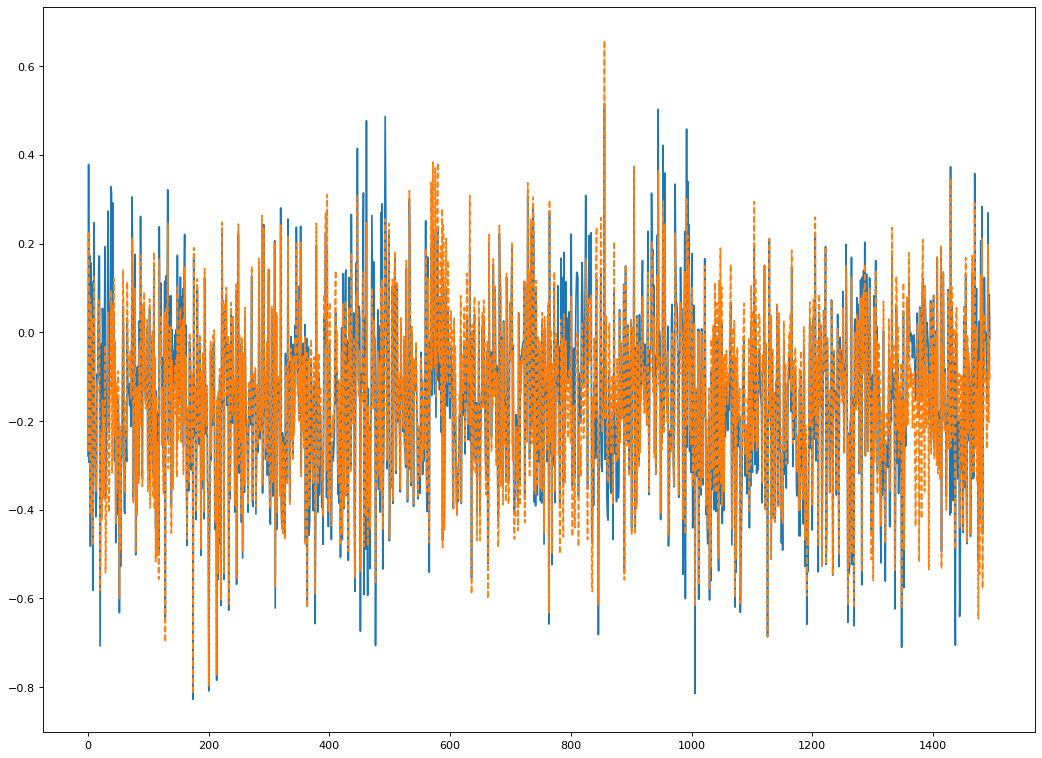

In [ ]:
feature = 150
y1 = X[:, feature]
y1_harmon = X_harmon[:, feature]

x1 = np.linspace(0, len(y1), len(y1))
plt.figure(figsize=(16, 12), dpi=80)
plt.plot(x1, y1)
plt.plot(x1, y1_harmon, linestyle = '--')


In [ ]:
feat = [10,45, 90, 120, 200,300, 350]
for i, f in enumerate(feat):
    plt.figure(i)
    data = X[:, f]
    x1 = np.arange(len(y1))
    data_harmon = harmon_data[:, f]
    plt.plot(x1, data)
    plt.plot(x1, data_harmon, linestyle = '--')


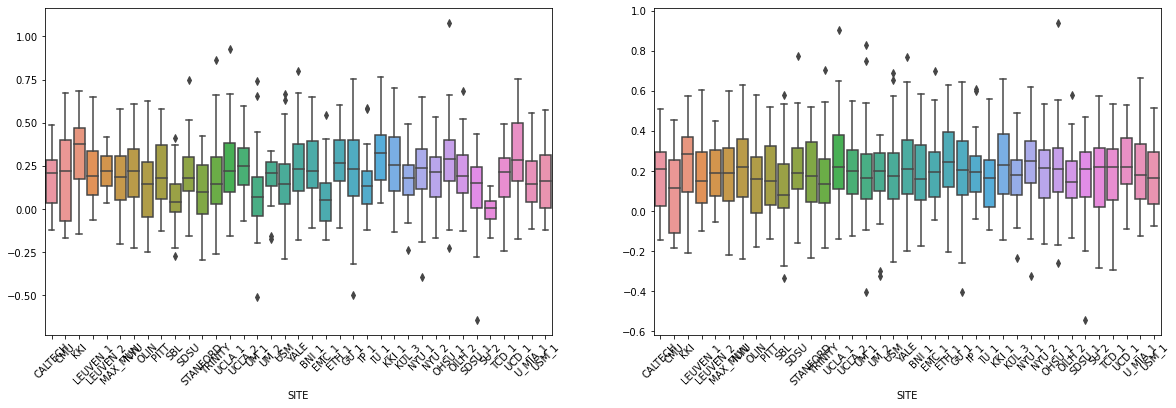

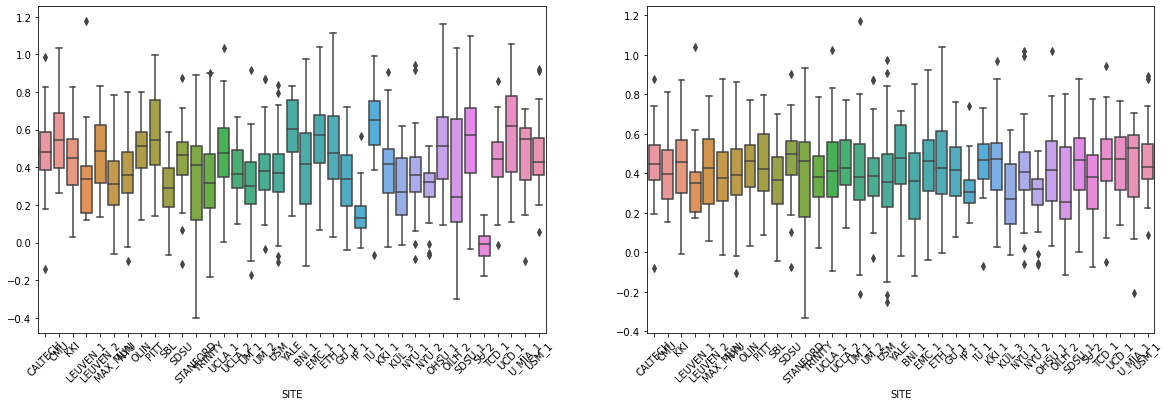

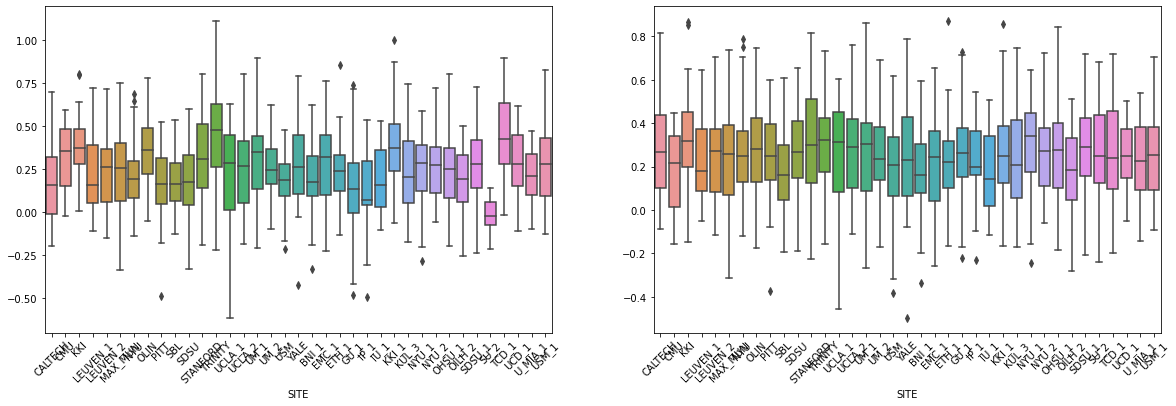

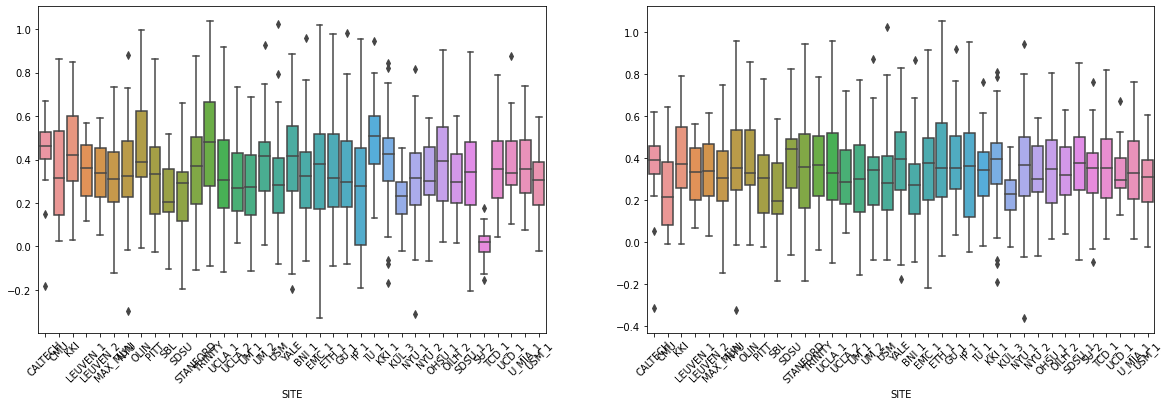

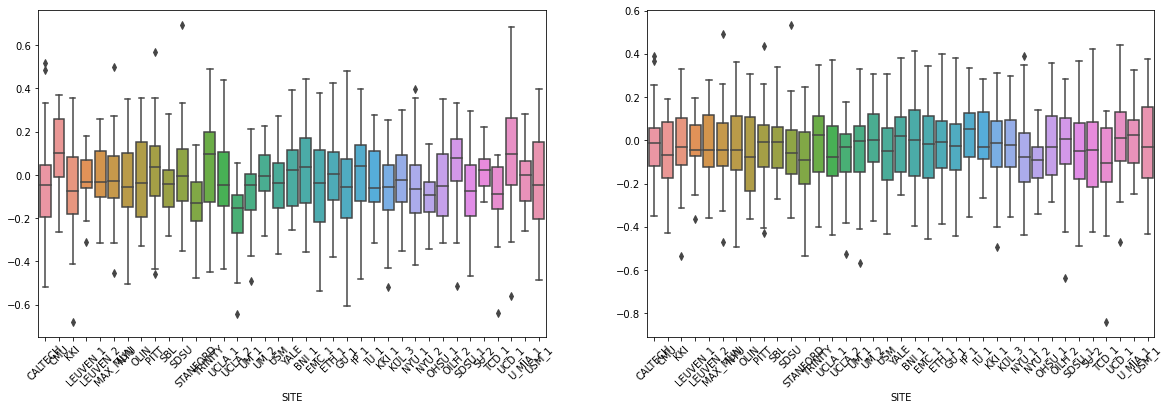

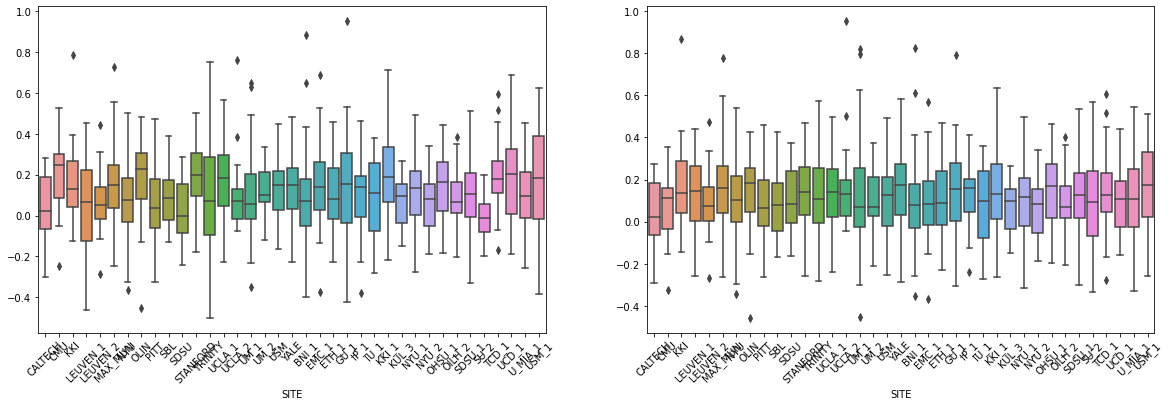

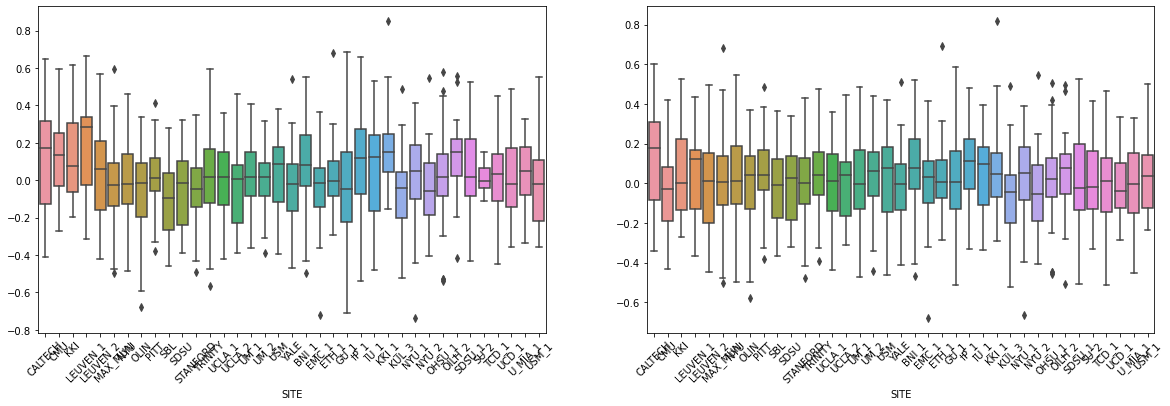

In [ ]:
import seaborn as sns

for i, f in enumerate(feat): 
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))
  sns.boxplot(x='SITE', y=X[:, f], data=df, orient='v', ax=ax1)
  ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 45)  
  sns.boxplot(x='SITE', y=X_harmon[:, f], data=df, orient='v', ax=ax2)
  ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 45)
  plt.title(f'Feature{f}')
  #fig2, ax2 = plt.subplots(1,1, figsize=(8, 6))
  

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))
sns.boxplot(x='SITE', y=X[:, 300], data=df, orient='v', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [ ]:
atlas = 'homask'
df1 = pd.read_csv(f'gdrive/MyDrive/MATLAB/data/dataset/df_homask_ab1_zscores&wave_new.csv')
df2 = pd.read_csv(f'gdrive/MyDrive/MATLAB/data/dataset/df_homask_ab2_zscores&wave_new.csv')
df2 = df2.rename(columns={"AGE_AT_SCAN ": "AGE_AT_SCAN"})

df3 = pd.read_csv(f'gdrive/MyDrive/files_homask_no83/df3_homask.csv')
df3 = df3.rename(columns={"Z_SCORE": "Z_DATA"})
#df1['ABIDE'] = 1
#df2['ABIDE'] = 0

df2['SITE'] = df2['SITE'] + max(df1.SITE)
df = pd.concat([df1, df2], ignore_index = True)



In [ ]:
df

In [ ]:
df3

In [ ]:
df = pd.concat([df, df3], ignore_index = True)
df

,Unnamed: 0,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,ADI_R_C3_TOTAL,ADI_R_C4_REPETITIVE_USE_OBJECTS,ADI_R_C4_HIGHER,ADI_R_C4_UNUSUAL_SENSORY_INTERESTS,ADI_R_C4_TOTAL,ADI_R_D_AGE_PARENT_NOTICED,ADI_R_D_AGE_FIRST_SINGLE_WORDS,ADI_R_D_AGE_FIRST_PHRASES,ADI_R_D_AGE_WHEN_ABNORMALITY,ADI_R_D_INTERVIEWER_JUDGMENT
0,0,CALTECH,51456,1,4.0,55.40,1,R,NaN,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CALTECH,51457,1,4.0,22.90,1,Ambi,NaN,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,CALTECH,51458,1,1.0,39.20,1,R,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,CALTECH,51459,1,1.0,22.80,1,R,NaN,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,CALTECH,51460,1,1.0,34.60,2,Ambi,NaN,133.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2255,29,PITT,50013,1,NaN,9.33,1,NaN,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2256,30,PITT,50031,2,NaN,12.92,1,NaN,NaN,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2257,31,PITT,50035,2,NaN,17.36,1,NaN,NaN,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2258,32,PITT,50027,1,NaN,12.24,1,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
